In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm.notebook import tqdm
sys.path.append(".")
import HOD
from astropy.cosmology import Planck15 as cosmo
h = cosmo.H(0).value/100
sigma_logM, alpha = 0.2, 1.0

In [2]:
plt.rcParams['figure.figsize'  ] = (3.3,2.0)
plt.rcParams['font.size'       ] = 16
plt.rcParams['axes.labelsize'  ] = 14
plt.rcParams['legend.fontsize' ] = 13
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.labelsize' ] = 16
plt.rcParams['ytick.labelsize' ] = 16
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1.25
plt.rcParams['xtick.minor.width'] = 0.75
plt.rcParams['ytick.major.width'] = 1.25
plt.rcParams['ytick.minor.width'] = 0.75

In [24]:
def get_z_and_N_array(z, m, VERBOSE = False):
    PATH = 'Harikane_z_distribution/'
    z1s, z2s = str(int(z//1)), str(int(np.around(10*(z - z//1), 0)))
    m1s, m2s = str(int(m//1)), str(int(100*(m - m//1))) if (m - m//1) != 0 else '00'
    filename = 'z_'+z1s+'.'+z2s+'_m_'+m1s+'.'+m2s+'.data'
    try:
        f = np.loadtxt(PATH+filename, delimiter=' ')
        z_array, N_z_nrm = f.T[0], f.T[1]
        N_z_nrm = N_z_nrm/np.trapz(N_z_nrm, z_array)
    except:
        if VERBOSE:
            print('Do not have that z and m combination in the database')
            print(PATH+filename)
        return None, None
    return z_array, N_z_nrm

def get_avg_Harikane(M_min, sigma_logM, M_sat, alpha, z, z_array, N_z_nrm, n_g = None, AVG_OVER_Z = False):
    if AVG_OVER_Z:
        a, b, c = np.zeros(0), np.zeros(0), np.zeros(0)
        for z in z_array:
            M_h_array, HMF_array, nu_array, _, __ = HOD.init_lookup_table(z)
            a = np.append(a, HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g))
            b = np.append(b, HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, nu_array, n_g=n_g))
            c = np.append(c, HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g))
        return np.log10(np.sum(a * N_z_nrm * np.diff(z_array)[0])),\
               np.sum(b * N_z_nrm * np.diff(z_array)[0]),\
               np.log10(np.sum(c * N_z_nrm * np.diff(z_array)[0]))
    M_h_array, HMF_array, nu_array, _, __ = HOD.init_lookup_table(z)
    return np.log10(HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g)),\
            HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, nu_array, n_g=n_g),\
            np.log10(HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, M_h_array, HMF_array, n_g=n_g))

def get_summary(z, m, M_min, M_sat, VERBOSE = False, sigma_logM = 0.2, alpha = 1):
    z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE)
    if z_array is not None:
        n_g = HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, N_z_nrm)
        logMh, beff, logfsat = get_avg_Harikane(M_min, sigma_logM, M_sat, alpha, z, z_array, N_z_nrm, n_g = n_g)
        if VERBOSE:
            print('Redshift: ', z)
            print('  ', 'M_min', 'M_sat')
            print('  ', np.log10(M_min), np.log10(M_sat))
            print('  ', 'logMh  ', 'beff ', 'logfsat')
            print(f'   {logMh:.2f} | {beff:.2f} | {logfsat:.2f}')
        return logMh, beff, logfsat
    return None, None, None

def plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat):
    fig, ax = plt.subplots(2,3, figsize=(14,4), sharex=True)
    m_array, i = np.arange(23.5, 27, 0.5), 0
    _col_ = iter(cm.viridis(np.linspace(0, 1, len(m_array))))
    for m in m_array:
        z_array, N_z_nrm = get_z_and_N_array(z, m, VERBOSE = False)
        _c_ = next(_col_)
        if z_array is not None:
            logMh, beff, logfsat = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                    M_sat_array[i], alpha,
                                                    z, z_array, N_z_nrm)
            ax[0, 0].scatter(m, logMh, c= _c_)
            ax[0, 1].scatter(m, beff, c= _c_)
            ax[0, 2].scatter(m, logfsat, c= _c_)
            ax[0, 0].scatter(m, H_log_avg_Mh[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 1].scatter(m, H_beff[i], edgecolors= _c_, marker = 'D', facecolors='none')
            ax[0, 2].scatter(m, H_log_fsat[i], edgecolors= _c_, marker = 'D', facecolors='none')
            if 0 :
                logMh, beff, logfsat = get_avg_Harikane(M_min_array[i], sigma_logM,
                                                        M_sat_array[i], alpha,
                                                        z, z_array, N_z_nrm,
                                                        AVG_OVER_Z = True)

                ax[0, 0].scatter(m, logMh, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 1].scatter(m, beff, edgecolors= _c_, marker = 'o', facecolors='none')
                ax[0, 2].scatter(m, logfsat, edgecolors= _c_, marker = 'o', facecolors='none')

            ax[1, 0].scatter(m, np.power(10, H_log_avg_Mh[i])/np.power(10, logMh), c= _c_)
            ax[1, 1].scatter(m, H_beff[i]/beff, c= _c_)
            ax[1, 2].scatter(m, np.power(10, H_log_fsat[i])/np.power(10, logfsat), c= _c_)
            ax[1, 0].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 1].axhline(1, ls='--', c = 'k', alpha = 0.5)
            ax[1, 2].axhline(1, ls='--', c = 'k', alpha = 0.5)
            i += 1
    ax[0, 0].set_title(r'$\log(M_h)$')
    ax[0, 1].set_title(r'$b_{eff}$')
    ax[0, 2].set_title(r'$\log(f_{sat})$')
    ax[1, 0].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 1].set_xlabel(r'$m^{th}_{UV}$')
    ax[1, 2].set_xlabel(r'$m^{th}_{UV}$')
    ax[0, 0].set_ylabel(f'z = {z}')
    ax[1, 0].set_ylabel(f'Ratio Harik/Me')
    ax[1, 0].set_ylim((0.5, 1.5))
    ax[1, 1].set_ylim((0.8, 1.2))
    ax[1, 2].set_ylim((0, 2))
    plt.show()

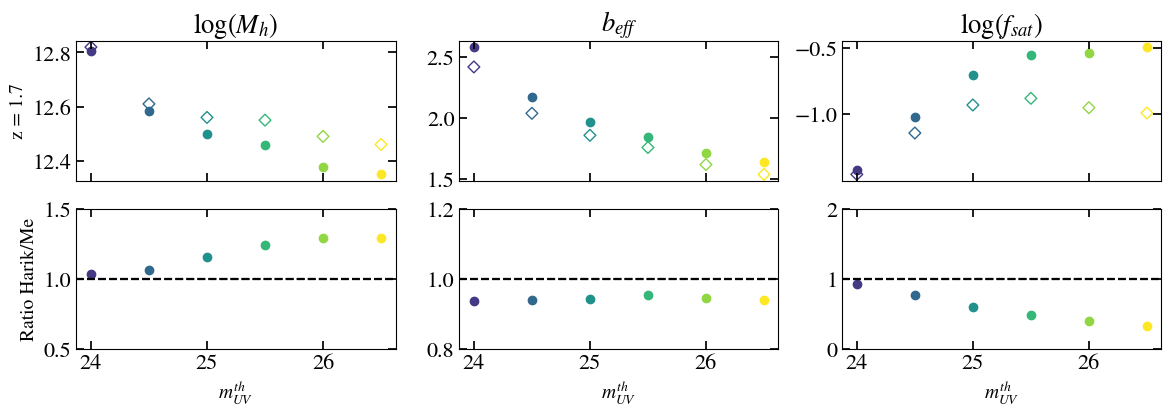

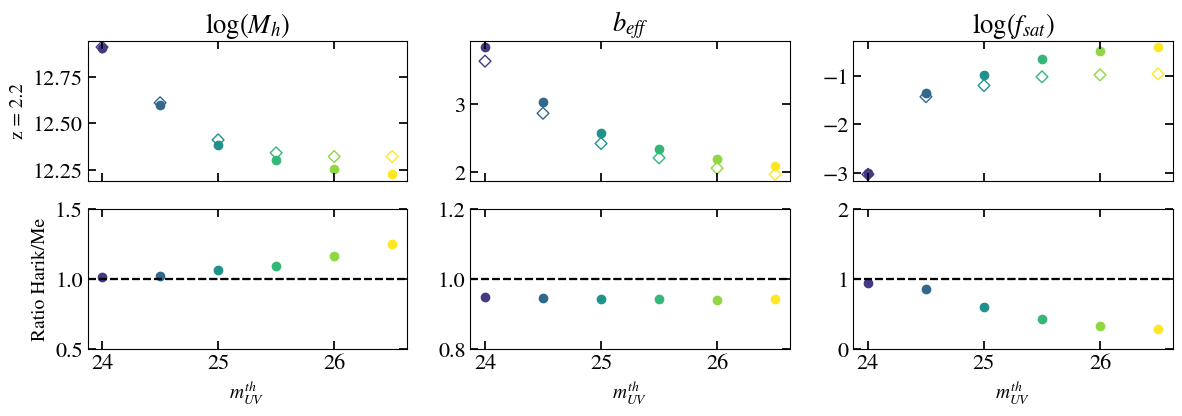

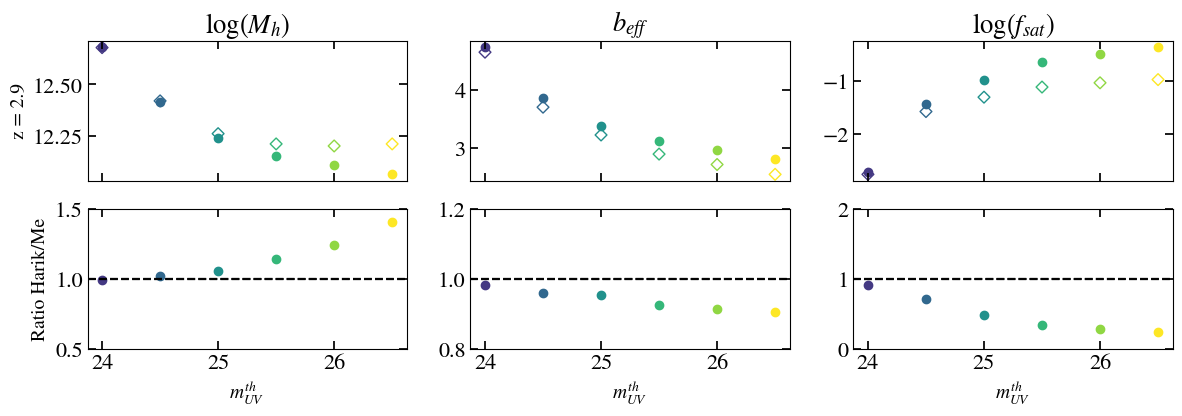

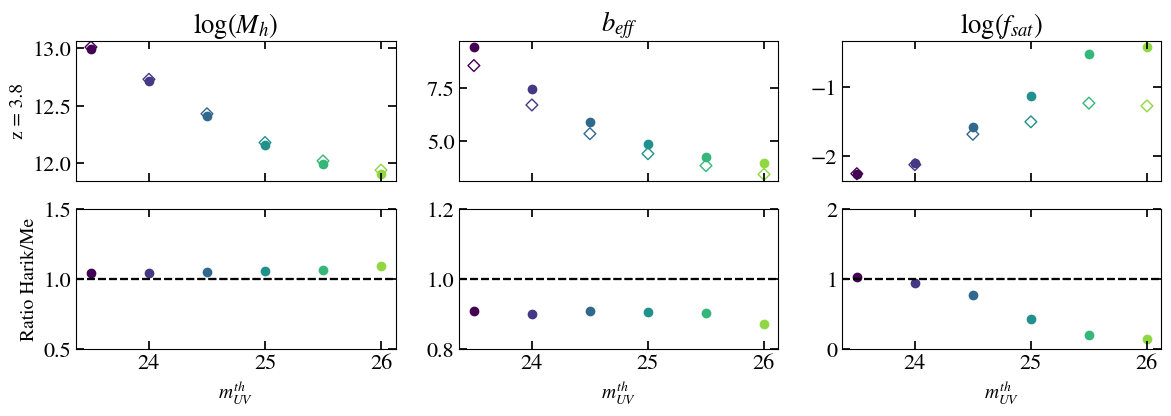

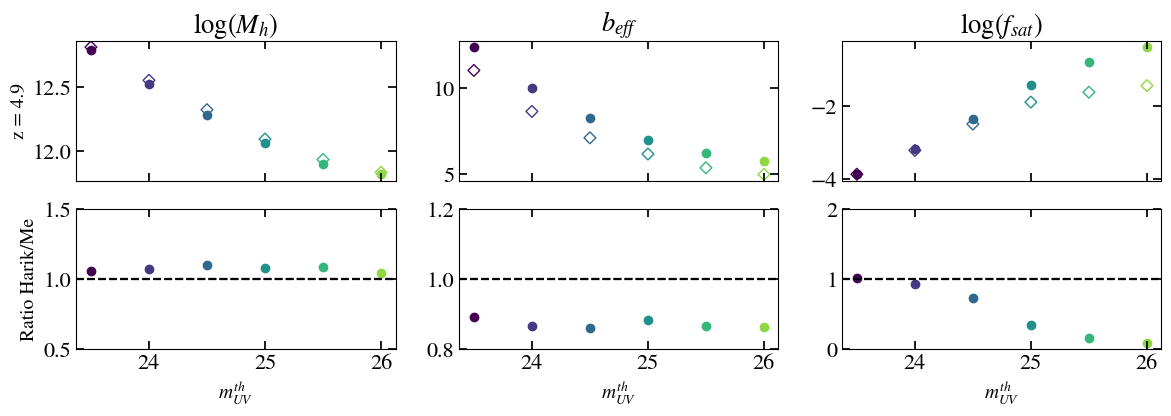

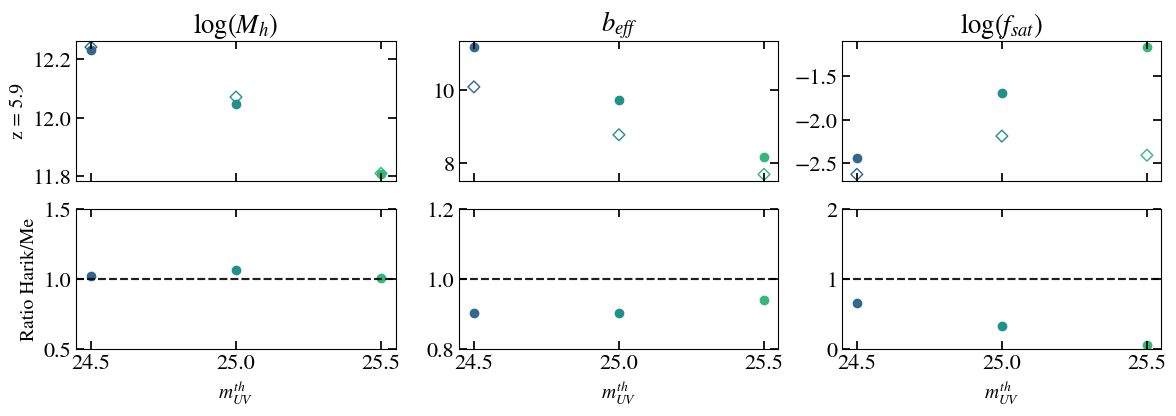

In [25]:
z= 1.7
log_M_min = np.array([12.46, 12.09, 11.79, 11.55, 11.33, 11.16])
log_M_sat = np.array([14.18, 13.47, 12.86, 12.48, 12.28, 12.08])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.82, 12.61, 12.56, 12.55, 12.49, 12.46])
H_beff       = np.array([2.42,  2.04,  1.86,  1.76,  1.62,  1.54])
H_log_fsat   = np.array([-1.45, -1.14, -0.93, -0.88, -0.95, -0.99])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)

z= 2.2
log_M_min = np.array([12.72, 12.30, 11.95, 11.68, 11.45, 11.26])
log_M_sat = np.array([15.91, 13.92, 13.23, 12.62, 12.23, 11.94])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.91, 12.61, 12.41, 12.34, 12.32, 12.32])
H_beff       = np.array([3.62,  2.86,   2.42,  2.21,  2.06,  1.97])
H_log_fsat   = np.array([-3.03, -1.43, -1.20, -1.02, -0.98, -0.96])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)

z= 2.9
log_M_min = np.array([12.55, 12.19, 11.92, 11.71, 11.55, 11.36])
log_M_sat = np.array([15.39, 13.80, 13.12, 12.55, 12.20, 11.84])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.68, 12.42, 12.26, 12.21, 12.20, 12.21])
H_beff       = np.array([4.66,  3.71,   3.23,  2.90,  2.72,  2.55])
H_log_fsat   = np.array([-2.75, -1.57, -1.30, -1.11, -1.03, -0.97])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)

z= 3.8
log_M_min = np.array([13.08, 12.71, 12.32, 11.98, 11.66, 11.48])
log_M_sat = np.array([15.25, 14.80, 13.96, 13.23, 12.24, 11.94])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([13.01, 12.73, 12.43, 12.18, 12.02, 11.94])
H_beff       = np.array([8.55,  6.70,   5.35,  4.41,  3.85,  3.44])
H_log_fsat   = np.array([-2.25, -2.12, -1.68, -1.50, -1.23, -1.27])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)

z= 4.9
log_M_min = np.array([12.95, 12.60, 12.29, 12.00, 11.76, 11.57])
log_M_sat = np.array([16.65, 15.70, 14.63, 13.45, 12.57, 11.86])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.81, 12.55, 12.32, 12.09, 11.93, 11.83])
H_beff       = np.array([11.02,  8.64,   7.11,  6.17,  5.37, 4.99])
H_log_fsat   = np.array([-3.86, -3.21, -2.49, -1.89, -1.62, -1.44])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)

z= 5.9
log_M_min = np.array([12.33, 12.09, 11.78])
log_M_sat = np.array([14.67, 13.73, 12.93])
M_min_array, M_sat_array = np.power(10, log_M_min), np.power(10, log_M_sat)
H_log_avg_Mh = np.array([12.24, 12.07, 11.81])
H_beff       = np.array([10.09,  8.77,  7.68])
H_log_fsat   = np.array([-2.63, -2.19, -2.41])
plot_comparison(z, M_min_array, M_sat_array, H_log_avg_Mh, H_beff, H_log_fsat)